In [1]:

import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import re
import os
import random
import tensorflow as tf
import plotly.express as px

from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, f1_score, confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B1
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from PIL import Image
from scipy.stats import skew
from tqdm import tqdm

2025-06-07 09:48:27.215657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749289707.592765      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749289707.704948      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Loading

In [2]:
# Four categories 
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# Download per category
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Non Demented'):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Very mild Dementia'):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Mild Dementia'):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Moderate Dementia'):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))

In [3]:
# How many samples in each category: 
print(len(non_demented))
print(len(very_mild_demented))
print(len(mild_demented))
print(len(moderate_demented))

67222
13725
5002
488


# Split for Test Set

In [4]:
# Set seed for random sampling
random.seed(42)


# Split off a test set for the moderate_demented class
moderate_demented_train, moderate_demented_test = train_test_split(
    moderate_demented, test_size=0.2, random_state=42
)

# Split off a test set for the mild_demented class
mild_demented_train, mild_demented_test = train_test_split(
    mild_demented, test_size=0.2, random_state=42
)

# Split off a test set for the very_mild_demented class
very_mild_demented_train, very_mild_demented_test = train_test_split(
    very_mild_demented, test_size=0.2, random_state=42
)

# Split off a test set for the non_demented class
non_demented_train, non_demented_test = train_test_split(
    non_demented, test_size=0.2, random_state=42
)

In [5]:
# Check number of train images per category
print(len(non_demented_train))
print(len(very_mild_demented_train))
print(len(mild_demented_train))
print(len(moderate_demented_train))

53777
10980
4001
390


# Handling Class Imbalance

As mentioned in the introduction and visible in our ‘Observations per Class’ histogram, our dataset was extremely imbalanced, with the minority class being only 0.007% the size of the majority class. Although the dataset’s class proportions reflect current prevalence of Alzheimer’s per category (with more severe forms of the disease naturally being less frequent than no diagnosis), this was not ideal in terms of neural network training. Datasets with such high imbalance can result in misleading outputs such as high performance on the majority class but low on the minority class, and deceptive performance interpretations when using common performance metrics such as accuracy (as it is often not suited for class imbalance). To this end, researching ways of countering this was one of our initial priorities.

The most problematic part of our case of class imbalance was the fact that we were working with medical brain scans. It is highly inadvisable to perform data augmentation through common techniques such as distortions, rotations, color changes, and even flips to medical data, as this could lead to potentially losing valuable information about brain structures along the way, and lead to erroneous diagnoses. Given the (medical) importance and implications of diagnosis, it would be too big a risk (and potentially unethical) to include such transformations to our data. Therefore, our ways of dealing with imbalance were quite limited, specifically in terms of augmentation.

We initially looked into data augmentation using SMOTE, weighted classes, undersampling, oversampling, and a weighted loss function. SMOTE was not applicable to our dataset; subsequently we compared performance using weighted classes to performance using a combination of undersampling (of the majority classes) and oversampling (of the minority classes). The former yielded very poor accuracy (probably because a large weight is given to the minority class so small discrepencies become very influential) whereas the latter performed extremely well, and is what we have chosen for our final (highly performing) model. Given the poor performance of weighted classes and its technical difficulty we opted to not include weighted loss functions.

Since oversampling involves resampling and using images from the dataset without changes (and hence using replicas of images to augment a class), before implementing it we split off a test set from each class’ raw data. This resulted in 98 images from the moderate class (20% of the 488 observations), and 640 images for the other 3 categories, to end up with 2000 images for the test set, which is 10% of the train sample size consisting of 20,000 images. It was not an issue that the test dataset was not proportional across classes, as it is appropriate for a test set to include a proportion that is closer to real-world occurrence of each class (in this case a lower incidence of “moderate” Alzheimer’s) rather than proportional for every class, as this will mirror more closely how the test fares for realistic diagnostic prediction. Then, with the remaining data, we undersampled from the two majority classes to obtain 5000 scans per class, and oversampled from the two minority classes to get 5000 images for each as well. We then performed an 80-20 train-validation split on this 20,000 image set, such that we had 16,000 images for training (4000 per class), and 4000 for validation (1000 per class). This is the data we used to train our model.

# Undersampling & Oversampling of Training Set

In [6]:
# Specify the target number of samples for each class
target_samples = 5000

# Oversample small classes
moderate_demented_samp = random.choices(moderate_demented_train, k=target_samples)
mild_demented_samp = random.choices(mild_demented_train, k=target_samples)

# Undersample large classes
very_mild_demented_samp = random.sample(very_mild_demented_train, k=target_samples)
non_demented_samp = random.sample(non_demented_train, k=target_samples)

In [8]:
# Check results
print(len(non_demented_samp))
print(len(very_mild_demented_samp))
print(len(mild_demented_samp))
print(len(moderate_demented_samp))

5000
5000
5000
5000


# Undersampling Test Data

In [9]:
# Check the number of test images per category
print(len(non_demented_test))
print(len(very_mild_demented_test))
print(len(mild_demented_test))
print(len(moderate_demented_test))

13445
2745
1001
98


In [10]:
# Specify the target number of samples for each class
target_samples = 640

# Undersample large classes
mild_demented_test = random.sample(mild_demented_test, k=target_samples)
very_mild_demented_test = random.sample(very_mild_demented_test, k=target_samples)
non_demented_test = random.sample(non_demented_test, k=target_samples)
moderate_demented_test = random.choices(moderate_demented_test, k=target_samples)

In [11]:
# Check the number of test images per category
print(len(non_demented_test))
print(len(very_mild_demented_test))
print(len(mild_demented_test))
print(len(moderate_demented_test))

640
640
640
640


In [12]:
# One-hot encoder for class labels 
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

# Train Data
We transformed the train images from each class into the preferred shape: 128x128x3. We choose 128 pixels to reduce computation time. The categories were merged together into the 'data' object. The class labels were transformed into the one-hot encoded format and stored into the 'result' object.

After this, we splitted this data into a training set (80%) and a validation set (20%).

In [13]:
# Empty objects to store the data and the class labels (result) in
data = []
result = []

# Loop through each category and transform data and result into right format (128x128x3 & one-hot encoded) 
# and merge categories together
for path in non_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

for path in very_mild_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

for path in mild_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray()) 
        
for path in moderate_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())

In [14]:
# Transform data to numpy array
data = np.array(data)

# Check shape
data.shape

(20000, 128, 128, 3)

In [15]:
# Transform labels to numpy array
result = np.array(result)

# Reshape to the one-hot encoded format 
result = result.reshape((data.shape[0],4)) 

# Check shape 
result.shape

(20000, 4)

In [16]:
# Split in validation and train data 
x_train,x_val,y_train,y_val = train_test_split(data,result, test_size=0.20, shuffle=True, random_state=42)

# Test Data
Also for the test data, we transformed the images from each class into the preferred shape (128x128x3) and merged the categories together into the 'data_test' object. Again, the class labels were transformed into the one-hot encoded format and stored into the 'result_test' object.

In [17]:
### Transforming the data into the right shape (128x128x3), merge and encode it 

data_test = []
result_test = []

for path in non_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[0]]).toarray())
        
for path in very_mild_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[1]]).toarray())

for path in mild_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[2]]).toarray()) 
        
for path in moderate_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[3]]).toarray())

In [18]:
# Transform data to numpy array
data_test = np.array(data_test)
data_test.shape

(2560, 128, 128, 3)

In [19]:
# Transform labels to numpy array
result_test = np.array(result_test)
result_test = result_test.reshape((data_test.shape[0],4)) 
result_test.shape

# Change names to x_test and y_test 
x_test = data_test
y_test = result_test

The data pre-processing thus resulted in the following data objects:


* x_train: train data
* y_train: train labels
* x_val: validation data (used in training/modeling)
* y_val: validation labels (used in training/modeling)
* x_test: test data (evaluation after modeling)
* y_test: test labels (evaluation after modeling)


# Main: SVM Model

### Feature Extraction
Histogram of Oriented Gradients (HOG) was selected as the primary feature extraction method prior to SVM classification. HOG is well-suited for medical imaging tasks, especially for structured patterns like in MRI scans, as it captures essential structural and edge-related information by computing gradient orientation histograms across localized regions of the image.

GPT Justification: Unlike raw pixel values, which can be high-dimensional and sensitive to noise, HOG offers a more compact and semantically meaningful representation of image content, enhancing the model’s ability to distinguish between stages of Alzheimer’s progression. This is especially beneficial when used with Support Vector Machines (SVMs), which are sensitive to high-dimensional input. By using HOG, the model benefits from both dimensionality reduction and increased feature robustness, without requiring a deep learning architecture

P.S.: Along with HOG, convert images to grayscale and flatten them (Vectorise). SVMs do not handle 3D image arrays (128×128×3) well, they require 1D (or 2D) feature vectors hence we flatten. Image is also grayscaled before HOG, bcs HOG is designed for gradient orientation/direction, not color. On top of that , SVM doesn't learn color pattern, and MRI scans don't carry meaningful color information.

In [20]:
from skimage.feature import hog
from skimage.color import rgb2gray


def extract_hog_features(img_list):
    hog_features = []
    for img in img_list:
        gray = rgb2gray(img)  
        features = hog(
            gray, 
            orientations=9, 
            pixels_per_cell=(8, 8), 
            cells_per_block=(2, 2), 
            block_norm='L2-Hys', 
            visualize=False, 
            feature_vector=True
        )
        hog_features.append(features)
    return np.array(hog_features)

# Apply HOG to training, validation, and test data
x_train_hog = extract_hog_features(x_train)
x_val_hog = extract_hog_features(x_val)
x_test_hog = extract_hog_features(x_test)

KeyboardInterrupt: 

In [32]:
print(x_train_hog.shape)
print(x_val_hog.shape)
print(x_test_hog.shape)

(16000, 8100)
(4000, 8100)
(2560, 8100)


### Feature Scaling
SVMs are sensitive to feature scale, so we need to normalize or standardize our inputs.

GPT justification: Feature scaling is essential for SVM because it ensures that all features contribute equally to the model, avoids distance distortion in kernels, and improves training stability and speed.
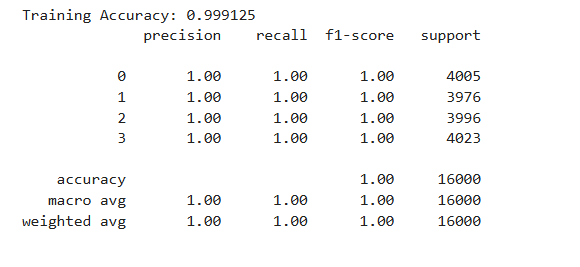

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_hog)
x_val_scaled = scaler.transform(x_val_hog)
x_test_scaled = scaler.transform(x_test_hog)

## (For comparison) Manually grayscaled and flattened

In [21]:
# Convert to grayscale and flatten
def prepare_for_svm(x_data):
    x_gray = np.mean(x_data, axis=3)  # Convert to grayscale
    x_flat = x_gray.reshape(x_gray.shape[0], -1)  # Flatten
    return x_flat

x_train_svm = prepare_for_svm(x_train)
x_val_svm = prepare_for_svm(x_val)
x_test_svm = prepare_for_svm(x_test)

# keep the scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_svm)
x_val_scaled = scaler.transform(x_val_svm)
x_test_scaled = scaler.transform(x_test_svm)

### Change labels format
Convert one-hot vectors to integer class labels. One hot encoding is suitable for neural networks, but SVM requires class labels in integer, not vectors.

In [22]:
y_train_svm = np.argmax(y_train, axis=1)
y_val_svm = np.argmax(y_val, axis=1)
y_test_svm = np.argmax(y_test, axis=1)

### PCA Dimensionality Reduction

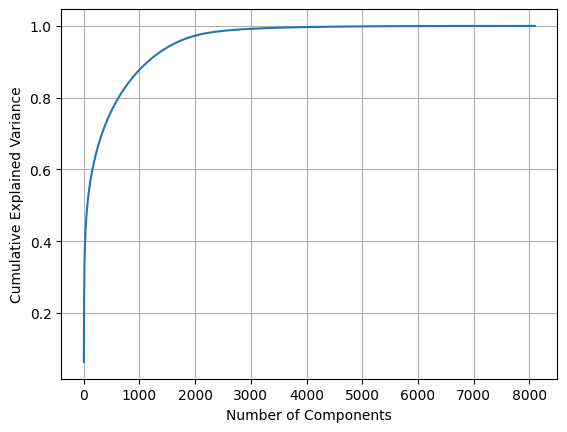

In [35]:
from sklearn.decomposition import PCA

# Find optimal PCA Components
pca = PCA().fit(x_train_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Choose the number of components that explains ~95% of the variance.

In [36]:
n_components_95 = np.argmax(explained_variance >= 0.95) + 1

print("Number of components to retain 95% variance:", n_components_95)

Number of components to retain 95% variance: 1616


In [38]:
# Choose the best number of components
pca = PCA(n_components=1616)
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_val_scaled)
x_test_pca = pca.transform(x_test_scaled)

print(x_train_pca.shape)
print(x_val_pca.shape)
print(x_test_pca.shape)

(16000, 1616)
(4000, 1616)
(2560, 1616)


### Hyperparameter Tuning
Search for the best settings for SVM

To balance runtime constraints and performance, the grid search was limited to high-performing combinations using kernel='rbf' and kernel='linear', which are widely used in SVM classification. The ‘poly’ and ‘sigmoid’ kernels were excluded due to excessive computational cost and limited improvement in initial experiments.”

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define hyperparameter grid
param_grid = {
    'C': [1, 10],                     # Removed extreme values 0.1, 100
    'gamma': ['scale'],              # Keep only standard scaling, removed 0.01, 0.001
    'kernel': ['rbf', 'linear']      # Dropped poly and sigmoid (very slow, often no gain)
}

# Set up Grid Search with 3-fold cross-validation
grid = GridSearchCV(SVC(), param_grid, cv=5)
#grid.fit(x_train_scaled, y_train_svm)
grid.fit(x_train_pca, y_train_svm)

# Get best model
best_svm = grid.best_estimator_
print("Best parameters:", grid.best_params_)
print("Best CV score (Validation score with best params):", grid.best_score_)


Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score (Validation score with best params): 0.9914999999999999


In [1]:
import pandas as pd

# Convert cv_results_ to a DataFrame
results_df = pd.DataFrame(grid.cv_results_)

# Show mean test score and individual fold scores
fold_cols = [col for col in results_df.columns if 'split' in col and 'test_score' in col]

# Print per-fold accuracy for each hyperparameter combination
for i, row in results_df.iterrows():
    print(f"Params: {row['params']}")
    for col in fold_cols:
        print(f"  {col}: {row[col]:.4f}")
    print(f"  Mean Accuracy: {row['mean_test_score']:.4f}")
    print("-" * 40)

NameError: name 'grid' is not defined

In [ ]:
for mean_score, params in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['params']):
    print(f"Mean Accuracy: {mean_score:.4f} | Params: {params}")


### Sensitivity and specificity

In [54]:
class_names = ["Non-Demented", "Very Mild", "Mild", "Moderate"]
def specifity(cm):
    print("Class-wise Sensitivity (Recall) and Specificity:")
    for i, class_name in enumerate(class_names):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FP + FN)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0

        print(f"  {class_name:10s} | Sensitivity: {sensitivity:.4f} | Specificity: {specificity:.4f}")

## Train SVM Model without PCA

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

import time

# Build SVM model
svm_model = SVC(kernel='rbf', C=1, gamma='scale')  #experiment with 'linear' or 'poly' too

# Start timer
train_start = time.time()

svm_model.fit(x_train_scaled, y_train_svm)

# End timer
train_end = time.time()
train_time = train_end - train_start
print(f"Training Time: {train_time:.2f} seconds") #measures how long .fit() takes


# Validation Set
val_start = time.time() # Validation set evaluation

y_val_pred = svm_model.predict(x_val_scaled)

val_end = time.time()
val_time = val_end - val_start
print(f"Validation Evaluation Time: {val_time:.2f} seconds") #measures how long .predict() + metrics take

print("Validation Accuracy:", accuracy_score(y_val_svm, y_val_pred))
print(classification_report(y_val_svm, y_val_pred, target_names=[
    "Non-Demented", "Very Mild", "Mild", "Moderate"
]))

Training Time: 845.13 seconds
Validation Evaluation Time: 1281.36 seconds
Validation Accuracy: 0.9925
              precision    recall  f1-score   support

Non-Demented       1.00      0.97      0.98       995
   Very Mild       0.97      1.00      0.99      1024
        Mild       1.00      1.00      1.00      1004
    Moderate       1.00      1.00      1.00       977

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



In [25]:
# Test Set
test_start = time.time() # Test set evaluation

y_test_pred = svm_model.predict(x_test_scaled)

test_end = time.time()
test_time = test_end - test_start
print(f"Test Evaluation Time: {test_time:.2f} seconds")

print("Test Accuracy:", accuracy_score(y_test_svm, y_test_pred))
print(classification_report(y_test_svm, y_test_pred, target_names=[
    "Non-Demented", "Very Mild", "Mild", "Moderate"
]))

Test Evaluation Time: 748.64 seconds
Test Accuracy: 0.9953125
              precision    recall  f1-score   support

Non-Demented       1.00      0.98      0.99       640
   Very Mild       0.98      1.00      0.99       640
        Mild       1.00      1.00      1.00       640
    Moderate       1.00      1.00      1.00       640

    accuracy                           1.00      2560
   macro avg       1.00      1.00      1.00      2560
weighted avg       1.00      1.00      1.00      2560



## Train SVM with PCA

In [53]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import time

In [57]:
# Train SVM on PCA-reduced data
svm_pca = SVC(kernel='rbf', C=10, gamma='scale')
train_start = time.time() 
svm_pca.fit(x_train_pca, y_train_svm)
train_end = time.time()
train_time = train_end - train_start
print(f"Training Time: {train_time:.2f} seconds")

Training Time: 233.88 seconds


In [58]:
test_start = time.time() 
y_test_pred_pca = svm_pca.predict(x_test_pca)
test_end = time.time()
test_time = test_end - test_start
print(f"Testing Evaluation Time: {test_time:.2f} seconds")

print("Test Accuracy (With PCA):", accuracy_score(y_test_svm, y_test_pred_pca))
print(classification_report(y_test_svm, y_test_pred_pca, target_names=[
    "Non-Demented", "Very Mild", "Mild", "Moderate"
]))


Testing Evaluation Time: 47.62 seconds
Test Accuracy (With PCA): 0.99765625
              precision    recall  f1-score   support

Non-Demented       1.00      0.99      1.00       640
   Very Mild       0.99      1.00      1.00       640
        Mild       1.00      1.00      1.00       640
    Moderate       1.00      1.00      1.00       640

    accuracy                           1.00      2560
   macro avg       1.00      1.00      1.00      2560
weighted avg       1.00      1.00      1.00      2560



### Plot Confusion Matrix

<Figure size 600x600 with 0 Axes>

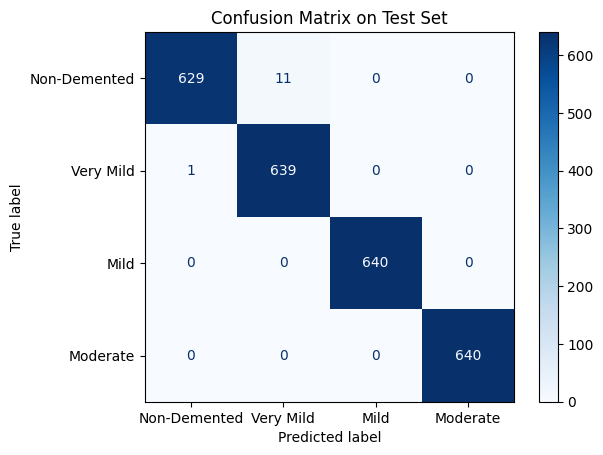

Testing set:
Class-wise Sensitivity (Recall) and Specificity:
  Non-Demented | Sensitivity: 0.9828 | Specificity: 0.9995
  Very Mild  | Sensitivity: 0.9984 | Specificity: 0.9943
  Mild       | Sensitivity: 1.0000 | Specificity: 1.0000
  Moderate   | Sensitivity: 1.0000 | Specificity: 1.0000


In [62]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
# Confusion Matrix
cm_test = confusion_matrix(y_test_svm, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[
    "Non-Demented", "Very Mild", "Mild", "Moderate"
])

# Plot the confusion matrix
#import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.show()


print("Testing set:")
specifity(cm_test)

<Figure size 600x600 with 0 Axes>

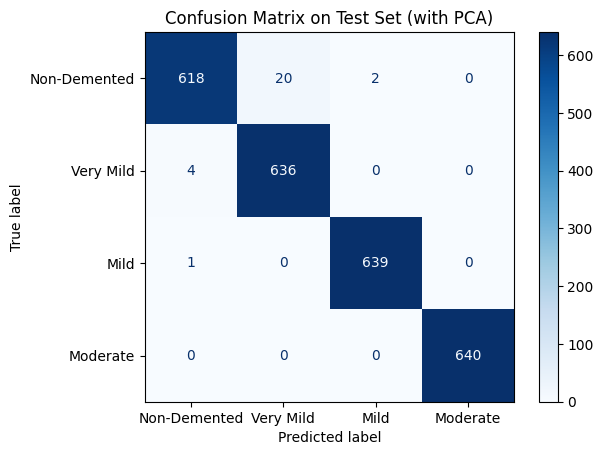

Testing set (with PCA):
Class-wise Sensitivity (Recall) and Specificity:
  Non-Demented | Sensitivity: 0.9656 | Specificity: 0.9974
  Very Mild  | Sensitivity: 0.9938 | Specificity: 0.9896
  Mild       | Sensitivity: 0.9984 | Specificity: 0.9990
  Moderate   | Sensitivity: 1.0000 | Specificity: 1.0000


In [56]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
# Confusion Matrix
cm_test = confusion_matrix(y_test_svm, y_test_pred_pca)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[
    "Non-Demented", "Very Mild", "Mild", "Moderate"
])

# Plot the confusion matrix
#import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix on Test Set (with PCA)")
plt.show()


print("Testing set (with PCA):")
specifity(cm_test)

### K-Fold Cross Validation
GPT justification: While the model achieved very high accuracy and F1-scores on both the validation and test sets, it's important to verify that this performance is not dependent on a specific train-test split. To address this, K-Fold Cross Validation was applied. This technique splits the training data into k equal parts (folds), trains the model on k−1 folds, and validates it on the remaining fold. This process is repeated k times, ensuring every sample is used for both training and validation.

By averaging performance across multiple folds, K-Fold Cross Validation provides a more reliable estimate of model generalization, reduces the risk of overfitting to one data subset, and improves confidence in the robustness of the model.

MIGHT SKIP THIS STEP BECAUSE : Hyperparameter tuning was conducted using 3-fold cross-validation via GridSearchCV (GridSearchCV already performed cross-validation (cv=3) to pick the best model). The best-performing model was then evaluated on independent validation and test sets, achieving consistently high classification performance. Given this stability and the computational expense, further k-fold validation was not conducted. [Model hyperparameters were tuned using 3-fold cross-validation via GridSearchCV. The selected model was then independently evaluated on a hold-out validation and test set. Given the strong and consistent performance across all sets, additional K-Fold validation was deemed unnecessary.}


In [40]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
import numpy as np

# Set up the model (can use best parameters from GridSearchCV)
svm_kfold = SVC(kernel='rbf', C=1, gamma='scale')

# Define 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation and get accuracy for each fold
scores = cross_val_score(svm_kfold, x_train_pca, y_train_svm, cv=kf, scoring='accuracy')

# Display results
print("Cross-validation scores (Accuracy per fold):", scores)
print("Mean Accuracy:", np.mean(scores))
print("Standard Deviation:", np.std(scores))


Cross-validation scores (Accuracy per fold): [0.980625  0.98625   0.9859375 0.9809375 0.9784375]
Mean Accuracy: 0.9824375
Standard Deviation: 0.0031087075288614794


In [42]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.svm import SVC
import numpy as np

# Define scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'macro_f1': make_scorer(f1_score, average='macro')
}

# Run cross-validation
results = cross_validate(svm_kfold, x_train_pca, y_train_svm, cv=kf, scoring=scoring, return_train_score=False)

# Print fold-wise results
for i in range(5):
    acc = results['test_accuracy'][i]
    f1 = results['test_macro_f1'][i]
    print(f"Fold {i+1} - Accuracy: {acc:.4f}, F1: {f1:.4f}")

# Print mean ± std
print(f"\nMean Accuracy: {np.mean(results['test_accuracy']):.4f} ± {np.std(results['test_accuracy']):.4f}")
print(f"Mean F1: {np.mean(results['test_macro_f1']):.4f} ± {np.std(results['test_macro_f1']):.4f}")


Fold 1 - Accuracy: 0.9806, F1: 0.9805
Fold 2 - Accuracy: 0.9862, F1: 0.9862
Fold 3 - Accuracy: 0.9859, F1: 0.9859
Fold 4 - Accuracy: 0.9809, F1: 0.9809
Fold 5 - Accuracy: 0.9784, F1: 0.9783

Mean Accuracy: 0.9824 ± 0.0031
Mean F1: 0.9824 ± 0.0031
